===== IMF slope estimation =====
True alpha                 : 2.350
MLE alpha (one realization): 2.356

Uncertainty estimates:
Theoretical (Fisher) σ_α   : 0.0446
MCMC posterior σ_α        : 0.0446


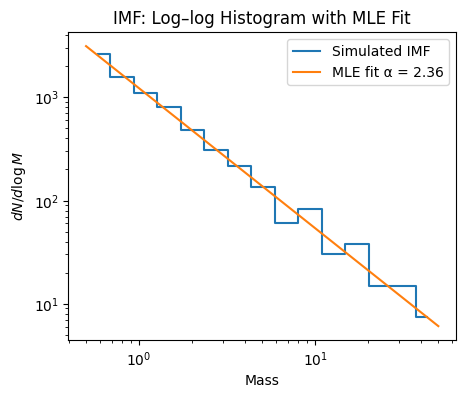

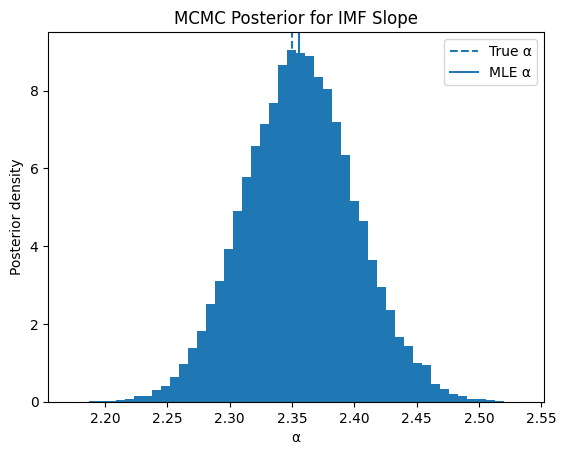

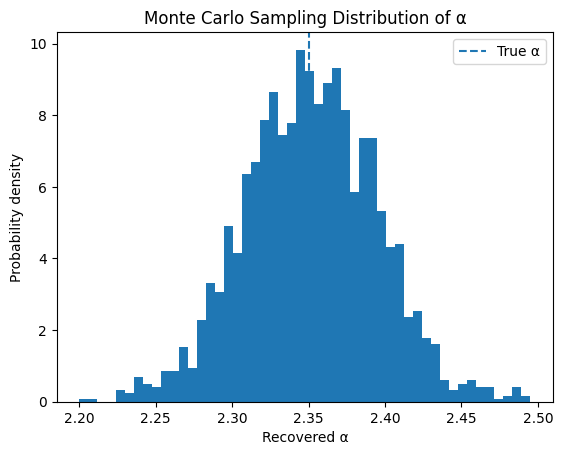

In [25]:
import numpy as np
import matplotlib.pyplot as plt

# =========================
# USER INPUTS
# =========================
N = 1000
alpha_true = 2.35
M_min = 0.5
M_max = 50.0
n_bins = 15

n_mc = 2000          # MC realizations
n_mcmc = 50000       # MCMC steps
burn_in = 5000

rng_seed = 42
# =========================

rng = np.random.default_rng(rng_seed)

# ---------------------------------------
# Draw from truncated power law
# ---------------------------------------
def draw_powerlaw(N, alpha, Mmin, Mmax):
    u = rng.random(N)
    a = 1.0 - alpha
    return (u * (Mmax**a - Mmin**a) + Mmin**a) ** (1.0 / a)

# ---------------------------------------
# Log-likelihood
# ---------------------------------------
def log_likelihood(alpha, masses, Mmin, Mmax):
    if alpha <= 1.0:
        return -np.inf
    a = 1.0 - alpha
    C = (1.0 - alpha) / (Mmax**a - Mmin**a)
    return len(masses) * np.log(C) - alpha * np.sum(np.log(masses))

# ---------------------------------------
# MLE via Newton-Raphson
# ---------------------------------------
def alpha_mle(masses, Mmin, Mmax):
    alpha = 2.0
    for _ in range(50):
        eps = 1e-6
        f = (log_likelihood(alpha + eps, masses, Mmin, Mmax)
             - log_likelihood(alpha - eps, masses, Mmin, Mmax)) / (2 * eps)
        df = (log_likelihood(alpha + eps, masses, Mmin, Mmax)
              - 2 * log_likelihood(alpha, masses, Mmin, Mmax)
              + log_likelihood(alpha - eps, masses, Mmin, Mmax)) / eps**2
        alpha -= f / df
    return alpha

# ---------------------------------------
# Fisher-information uncertainty
# ---------------------------------------
def sigma_alpha_theory(alpha, N, Mmin, Mmax):
    R = Mmax / Mmin
    term = (
        1.0 / (alpha - 1.0)**2
        - (R**(alpha - 1.0) * np.log(R)**2) / (R**(alpha - 1.0) - 1.0)**2
    )
    return 1.0 / np.sqrt(N * term)

# ---------------------------------------
# One realization
# ---------------------------------------
masses = draw_powerlaw(N, alpha_true, M_min, M_max)
alpha_hat = alpha_mle(masses, M_min, M_max)

# ---------------------------------------
# MCMC posterior (Metropolis)
# ---------------------------------------
chain = np.empty(n_mcmc)
chain[0] = alpha_hat
logp0 = log_likelihood(chain[0], masses, M_min, M_max)

proposal_width = 0.05

for i in range(1, n_mcmc):
    proposal = rng.normal(chain[i-1], proposal_width)
    logp1 = log_likelihood(proposal, masses, M_min, M_max)
    if np.log(rng.random()) < (logp1 - logp0):
        chain[i] = proposal
        logp0 = logp1
    else:
        chain[i] = chain[i-1]

chain = chain[burn_in:]
alpha_mcmc_mean = chain.mean()
alpha_mcmc_std = chain.std(ddof=1)

# ---------------------------------------
# Monte Carlo sampling uncertainty
# ---------------------------------------
alpha_mc = np.empty(n_mc)

for i in range(n_mc):
    m = draw_powerlaw(N, alpha_true, M_min, M_max)
    alpha_mc[i] = alpha_mle(m, M_min, M_max)

alpha_mc_std = alpha_mc.std(ddof=1)

# ---------------------------------------
# Print results
# ---------------------------------------
sigma_theory = sigma_alpha_theory(alpha_hat, N, M_min, M_max)

print("===== IMF slope estimation =====")
print(f"True alpha                 : {alpha_true:.3f}")
print(f"MLE alpha (one realization): {alpha_hat:.3f}")
print("")
print("Uncertainty estimates:")
print(f"Theoretical (Fisher) σ_α   : {sigma_theory:.4f}")
print(f"MCMC posterior σ_α        : {alpha_mcmc_std:.4f}")
#print(f"MC sampling σ_α           : {alpha_mc_std:.4f}")

# ======================================================
# ======================= PLOTS ========================
# ======================================================

# ---- (1) IMF histogram + MLE model in log–log space
bins = np.logspace(np.log10(M_min), np.log10(M_max), n_bins + 1)
counts, edges = np.histogram(masses, bins=bins)

centers = np.sqrt(edges[:-1] * edges[1:])
dlogM = np.log10(edges[1:] / edges[:-1])
phi = counts / dlogM

mask = counts > 0

M_plot = np.logspace(np.log10(M_min), np.log10(M_max), 400)
Gamma_hat = alpha_hat - 1.0
phi_model = (
    N * Gamma_hat * np.log(10)
    * M_plot**(-Gamma_hat)
    / (M_min**(-Gamma_hat) - M_max**(-Gamma_hat))
)



plt.figure(figsize=(5,4))
plt.loglog(centers, phi, drawstyle='steps-mid', label='Simulated IMF')
plt.loglog(M_plot, phi_model, label=f'MLE fit α = {alpha_hat:.2f}')
plt.xlabel('Mass')
plt.ylabel(r'$dN/d\log M$')
plt.legend()
plt.title('IMF: Log–log Histogram with MLE Fit')
plt.show()

# ---- (2) MCMC posterior
plt.figure()
plt.hist(chain, bins=50, density=True)
plt.axvline(alpha_true, linestyle='--', label='True α')
plt.axvline(alpha_hat, label='MLE α')
plt.xlabel('α')
plt.ylabel('Posterior density')
plt.legend()
plt.title('MCMC Posterior for IMF Slope')
plt.show()

# ---- (3) Monte Carlo sampling distribution
plt.figure()
plt.hist(alpha_mc, bins=50, density=True)
plt.axvline(alpha_true, linestyle='--', label='True α')
plt.xlabel('Recovered α')
plt.ylabel('Probability density')
plt.legend()
plt.title('Monte Carlo Sampling Distribution of α')
plt.show()


In [2]:
err1 = [0.35, 0.155, 0.043]
err2 = [0.37, 0.158, 0.045]
err3 = [0.50, 0.198, 0.059]

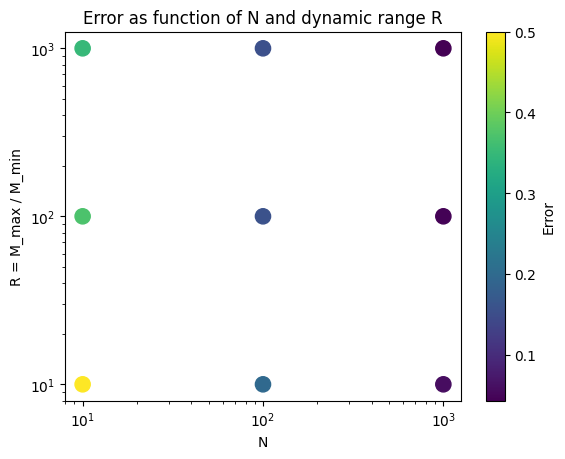

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Data
N_vals = np.array([10, 100, 1000])
R_vals = np.array([1000, 100, 10])

err1 = np.array([0.35, 0.155, 0.043])  # R = 1000
err2 = np.array([0.37, 0.158, 0.045])  # R = 100
err3 = np.array([0.50, 0.198, 0.059])  # R = 10

# Build grid
N_grid, R_grid = np.meshgrid(N_vals, R_vals)
errors = np.vstack([err1, err2, err3])

# Flatten for scatter
N_flat = N_grid.flatten()
R_flat = R_grid.flatten()
err_flat = errors.flatten()

# Plot
plt.figure()
sc = plt.scatter(N_flat, R_flat, c=err_flat, s=120)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('N')
plt.ylabel('R = M_max / M_min')
plt.colorbar(sc, label='Error')
plt.title('Error as function of N and dynamic range R')
plt.show()


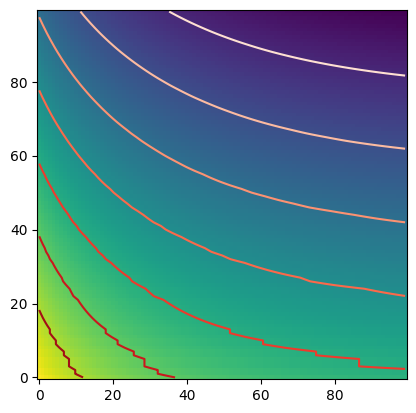

In [27]:
grid = np.zeros((100,100))

m, n = 0, 0
for N in np.logspace(0.8,3.3,100):
    n = 0
    for R in np.logspace(0.2,1.5,100):
        sigma_theory = sigma_alpha_theory(2.35, int(N+0.5), 0.2, R*0.2)
        grid[m, n] = sigma_theory
        n += 1
    m+=1

plt.imshow(np.log10(grid), origin='lower')
plt.contour(np.log10(grid), levels=8, cmap='Reds')

In [18]:
df.Mmin[i]

' 0.4'

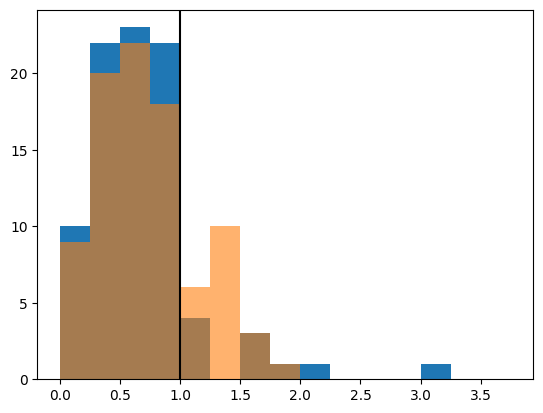

In [28]:
vals = []
vals2 = []

for i in range(len(df)):
    N = 10**float(df['log(N)'][i])
    M_min = float(df.Mmin[i])
    M_max = float(df.Mmax[i])
    alpha_hat = float(df.alpha[i])
    te = sigma_alpha_theory(alpha_hat, N, M_min, M_max)
    ae = float(df.e_alpha[i])
    vals.append(ae/te)
    vals2.append(float(df.Dalpha[i]))

plt.hist(vals, bins=np.arange(0,4,0.25))
plt.hist(vals2, bins=np.arange(0,4,0.25), alpha=0.6)
plt.axvline(1, color='k')

In [15]:
import pandas as pd
df = pd.read_csv('imf.tsv', sep='\t', comment='#')
df = df[2:].reset_index(drop=True)
df

,Seq,Name,log(N),log(Mm/Mc),alpha,e_alpha,Mmin,Mmax,Dalpha,Aut,BibCode,SimbadName,NED,_RA,_DE
0,1,NGC 2323,3.31,0.99,2.94,0.15,0.4,3.9,1.66,Kalirai et al.,2003AJ....126.1402K,NGC 2323,NED,105.6979,-08.3378
1,2,M11,3.26,0.49,2.49,0.09,1.1,3.4,0.32,Santos et al.,2005A&A...442..201S,M11,NED,282.7708,-06.2700
2,3,NGC 663,3.15,0.80,2.38,0.22,1.6,10.0,1.54,Pandey et al.,2005MNRAS.358.1290P,NGC 663,NED,026.5375,+61.2350
3,4,NGC 2168,3.00,0.78,2.29,0.27,0.6,3.6,1.76,Kalirai et al.,2003AJ....126.1402K,NGC 2168,NED,092.2250,+24.3333
4,5,NGC 2422,2.60,0.44,3.07,0.08,0.9,2.5,0.23,Prisinzano et al.,2003A&A...404..927P,NGC 2422,NED,114.1458,-14.4833
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84,85,NGC 7380,1.04,0.81,2.70,0.30,10.0,65.0,0.51,Massey et al.,1995ApJ...454..151M,NGC 7380,NED,341.8375,+58.1317
85,86,Berkeley86,1.00,0.60,2.70,0.40,10.0,40.0,0.49,Massey et al.,1995ApJ...454..151M,Berkeley86,NED,305.0500,+38.6900
86,87,NGC 2323,0.90,0.20,4.42,1.73,5.0,7.9,1.36,Tarrab,1982A&A...109..285T,NGC 2323,NED,105.6979,-08.3378
87,88,NGC 6913,0.78,0.60,2.10,0.60,10.0,40.0,0.72,Massey et al.,1995ApJ...454..151M,NGC 6913,NED,305.9833,+38.5233
